# Popular or Unpopular - Online News Article Popularity Prediction

# 1. Problem Formulation and Motivation

## 1.1. Business Goals: 

Given fast technology advancement and an increasing popularity of smart phones and gadgets, we have seen an increasing demand for online news, thus the capability to predict popularity of the articles published online. We believe that such business problem is worth investigating since it will help publishers and editors maximize marketing reaches and cater future articles to readers’ preferences, while enabling companies to increase profits from advertisements if applicable. To be more precise, the result of this project could be adopted by companies to predict the popularity of each article prior to its publication. It can inform businesses on how to write a popular article in great detail, including channel, keywords, title subjectivity, title polarity, time of publication, number of images to present, number of links to include, etc. 

## 1.2. Data Science Goals: 

We formed the following data science goals to achieve such interesting business goals: 

1. To build a binary classification (unpopular, popular) model to predict popularity of news article.
2. To develop a multinomial classification with 3 levels of popularity (low, medium, high).
3. To explore the data visualization and real-time model evaluations to look for interesting patterns which might play some role in the target prediction.
4. To build a descriptive model that provides insights on current customers’ preferences, hence to better select articles accordingly to increase number of views
5. To conduct a regression model on predicting the exact number of shares for each article.


# 2. Baseline Model 

In [1]:
# Importing packages
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer

import statsmodels.api as sm
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import model_selection

In [2]:
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score

In [3]:
import xgboost
import metrics 
import os
import time
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path = os.getcwd()
path

'/Users/xueyingxu/Documents/Fall-2018/1001/project/online-news-popularity'

In [5]:
#raw_data = pd.read_csv('/Users/nhungle/Box/Free/Data-Science-Projects/News Popularity/OnlineNewsPopularity.csv')

raw_data = pd.read_csv(path + '/OnlineNewsPopularity.csv')
raw_data.columns = raw_data.columns.str.strip()
data = raw_data

In [6]:
# Verify if all columns are numerical 
object_col = data.select_dtypes(include='object')
num_col = list(data.select_dtypes(include='int64').columns)
#object_col.drop('Type', axis = 1)
object_col = list(object_col.columns)
print(object_col)
#print(num_col)

['url']


** Note ** 'url is the only objective column, so we need to encode it first

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from numpy import array

In [8]:
#Label Encode object variables
for col in object_col: 
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(list(data[col].values))

In [9]:
object_col = data.select_dtypes(include='object')
object_col = list(object_col.columns)
print('Number of object columns after encoding is: {}'.format(len(object_col)))

Number of object columns after encoding is: 0


## 2.1. Exploring targeted variable

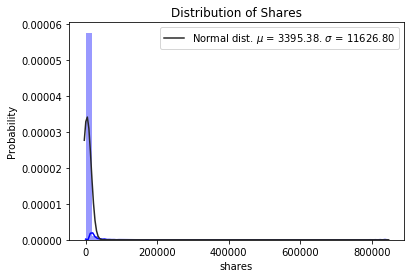

In [10]:
y = (data['shares'])
(mu, sigma) = norm.fit(y)
sns.distplot(y, fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Shares')
plt.show()

In [11]:
#Statistics of column shares
data.describe().iloc[:, -1]

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

**Note**: Using the distribution plot and looking at statistics of the 'shares' column, we can see that the number of shares do not follow a normal distribution and there are a very long long tail. This means although on average, articles receive around 3,400 shares, there is a large range of number of shares from 1 to 843,300. 

Thus, we decided to log transform number of shares before running a regression.

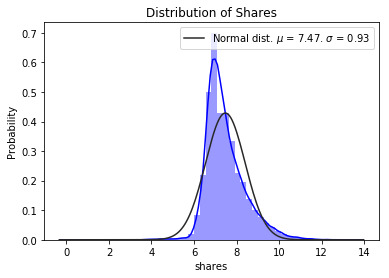

In [12]:
y = np.log(data['shares'])
(mu, sigma) = norm.fit(y)
sns.distplot(y, fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Shares')
plt.show()

**Note**: Although the number of shares are not fully normally distributed, log transforming the shares reduce the huge gaps of shares between articles, and we can start predicting number of shares using regression.

## 2.2. Root mean square error

This metric represents the sample standard deviation of the difference between predicted values and observed values (called residuals) 

In [13]:
#Def fine rmsq function
def rmse(log_y_pred, log_y_true): 
    return np.sqrt((np.average((log_y_pred - log_y_true)**2)))

In [14]:
def ValRMSE_base(X_train, Y_train, model, k): 
    kf = KFold(n_splits = k)
    scores = []
    train_scores = []
    for cv_train, cv_validate in kf.split(X_train): 
        X_cv_train = X_train.iloc[cv_train]
        X_cv_validate = X_train.iloc[cv_validate]
        
        Y_cv_train = Y_train.iloc[cv_train]
        log_y_cv_train = np.log(Y_cv_train)
        
        Y_cv_validate = Y_train.iloc[cv_validate]
        log_y_cv_validate = np.log(Y_cv_validate)
        model.fit(X_cv_train, log_y_cv_train)
        log_y_pred = model.predict(X_cv_validate)
        scores.append(rmse(log_y_pred, log_y_cv_validate))
        
        log_y_train_pred = model.predict(X_cv_train)
        train_scores.append(rmse(log_y_cv_train, log_y_train_pred))
    return (np.array(scores), np.array(train_scores))

In [15]:
X_train_base = data.drop('shares', axis = 1)
Y_train_base = data['shares']

## 2.3. Regression 


### 2.3.1. Multiple linear regression

In [16]:
Multiple_linear = LinearRegression()
scores, train_scores = ValRMSE_base(X_train_base, Y_train_base, Multiple_linear, 5)
print("\nMultiple Linear score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nMultiple Linear train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Multiple Linear score: 1.0816 (0.3512)


Multiple Linear train score: 0.8676 (0.0119)



### 2.3.2. Lasso

In [17]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))
scores, train_scores = ValRMSE_base(X_train_base, Y_train_base, lasso, 5)
print("\nLasso score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLasso train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Lasso score: 0.9123 (0.0787)


Lasso train score: 0.8708 (0.0121)



**Note**: For both linear regression and the Lasso regression, Root Mean Squared Error score of in-sample data is much better than score of out-sample data, indicating overfitting. However, the RMSE of the test set are still high (1.086 and 0.912 for linear regression and the Lasso regression respectively). This means there is room for improvement if we engineer features and select a better model. 

## 2.4. Binary Classification

We will use the threshold of 1400 shares as the threshold for popularity (i.e., if the number of shares >= 1400 then it is popular, else it is not popular

In [18]:
base_data = data.copy()
base_data['popular'] = 1
base_data.loc[data['shares'] < 1400, 'popular'] = 0
X_train_base = base_data.drop(['shares', 'popular'], axis = 1)
Y_train_base = base_data['popular']

In [19]:
from sklearn.metrics import roc_auc_score
def AUCScore_base(X_train, Y_train, model, k): 
    kf = KFold(n_splits = k)
    scores = []
    train_scores = []
    for cv_train, cv_validate in kf.split(X_train): 
        X_cv_train = X_train.iloc[cv_train]
        X_cv_validate = X_train.iloc[cv_validate]
        Y_cv_train = Y_train.iloc[cv_train]
        Y_cv_validate = Y_train.iloc[cv_validate]
        
        model.fit(X_cv_train, Y_cv_train)
        Y_validate_pred = model.predict_proba(X_cv_validate)[:, 1]
        Y_train_pred = model.predict_proba(X_cv_train)[:, 1]
        
        scores.append(roc_auc_score(Y_cv_validate, Y_validate_pred))
        train_scores.append(roc_auc_score(Y_cv_train, Y_train_pred))
    return (np.array(scores), np.array(train_scores))

In [20]:
logreg = LogisticRegression(solver = 'lbfgs')
scores, train_scores = AUCScore_base(X_train_base, Y_train_base, logreg, 5)
print("\nLogistic Regression score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLogistic Regression train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Logistic Regression score: 0.6074 (0.0345)


Logistic Regression train score: 0.6243 (0.0045)



# 3. Regression

In [21]:
X = data.drop('shares', axis = 1)
Y = data['shares']

In [22]:
def rmse_cal(model, X_train, Y_train, X_test, Y_test): 
    log_y_train = np.log(Y_train)
    log_y_test = np.log(Y_test)
    model.fit(X_train, log_y_train)
    log_y_pred = model.predict(X_test)
    return(rmse(log_y_test, log_y_pred))

## 3.1. Lasso Tuning Parameter

In [23]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [24]:
alpha_lasso = [i for i in frange(0.05, 0.15, 0.01)]

In [25]:
#alpha_lasso

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
rmse_lasso = {}
for alpha in alpha_lasso:
    rmse_alpha = []
    for num_fold in range(10): 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
        model = make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))
        rmse_alpha.append(rmse_cal(model, X_train, Y_train, X_test, Y_test))
    rmse_lasso[alpha] = rmse_alpha

In [28]:
#rmse_lasso

In [29]:
mse_avg = {alpha: np.average([i**2 for i in rmse_lasso[alpha]]) for alpha in alpha_lasso }

In [30]:
mse_avg

{0.05: 1.3619262352886956,
 0.060000000000000005: 1.2884446483081193,
 0.07: 1.09360408737776,
 0.08: 0.9070870549919003,
 0.09: 1.0703152845229282,
 0.09999999999999999: 1.295490402051565,
 0.10999999999999999: 0.9416240029384841,
 0.11999999999999998: 1.8065264705267787,
 0.12999999999999998: 1.391322000101609,
 0.13999999999999999: 1.2753809683834512}

In [31]:
x_axis = list(mse_avg.keys())

In [32]:
y_axis = list(mse_avg.values())

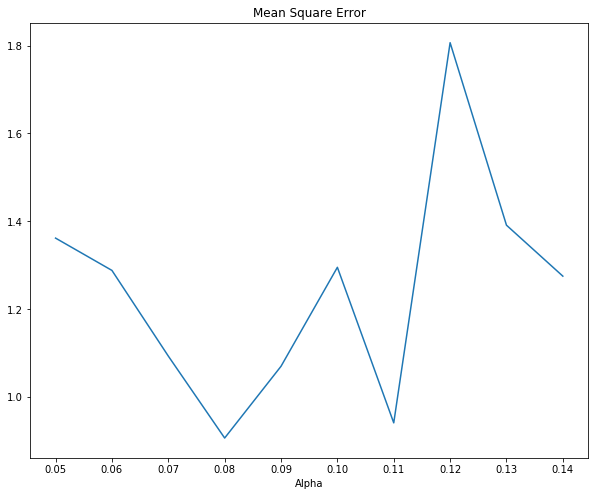

In [33]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
plt.plot(x_axis, y_axis, label = 'Alpha = {}'.format(alpha))
#ax.legend(loc = 'upper center', bbox_to_anchor = (1.5, 1),
#        fancybox = True, shadow = True, ncol = 1, prop = {'size': 15})
plt.title('Mean Square Error')
plt.xlabel('Alpha')
plt.xticks(np.arange(min(x_axis), max(x_axis)+0.01, 0.01))
plt.show()

Best alpha is 0.11999

In [34]:
#RMSE for Lasso at alpha 0.q
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.11999, random_state=1))
scores, train_scores = ValRMSE_base(X, Y, lasso, 10)
print("\nLasso score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLasso train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Lasso score: 1.0773 (0.4850)


Lasso train score: 0.9099 (0.0065)



## 3.2. XGBoost

In [36]:
import xgboost
from xgboost.sklearn import XGBClassifier 

In [37]:
xgb = XGBClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)

In [ ]:
scores, train_scores = ValRMSE_base(X, Y, xgb, 5)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nXGBoost train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))

In [ ]:
xgb_fs = XGBClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)
xgb_fs.fit(X_train_fs, y_train_fs)

## 3.3. PCA

Given 61 features, we would like to apply Principle Component Analysis to reduce dimension of the data. What PCA does is to project our original data of 61-dimensional subspace to a lower k-dimensional subspace to reserve as much variances as possible. The goal is to select a bucket of features that capture the most information about the dataset.  

In [38]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [39]:
n_components = [i for i in range(1, 61)]
#n_components
pca_var = []
for i in n_components: 
    pca = PCA(n_components = i)
    pca.fit(X)
    var = np.cumsum((pca.explained_variance_ratio_)*100) 
    pca_var.append(var[-1])

In [40]:
pca_var

[8.485701289689075,
 15.631073549043773,
 21.66891625327674,
 26.72364058757863,
 31.72192555825655,
 36.11733260447986,
 40.37728411528244,
 44.20941151153742,
 47.77930271804587,
 51.26375354674762,
 54.601913770948606,
 57.74841532544701,
 60.55954068434402,
 62.833471669680385,
 65.14346207502864,
 67.2008277769979,
 69.23953027677811,
 71.24616027419657,
 73.24461226206716,
 75.19255859740078,
 77.096479895722,
 78.90518368034577,
 80.64879084697947,
 82.19097475442548,
 83.6444594171738,
 85.02550227460803,
 86.22993688306315,
 87.36957816944526,
 88.49322372395456,
 89.52130221451736,
 90.53122280099623,
 91.483126854341,
 92.41358791859055,
 93.30371178218024,
 94.08811216114405,
 94.85414772004258,
 95.58707833821649,
 96.19436331029684,
 96.7241100661825,
 97.22508243214146,
 97.63227772535788,
 98.03293385696831,
 98.3974092217511,
 98.71277079536168,
 99.01722050788769,
 99.23276541773853,
 99.39512534932958,
 99.52826810575255,
 99.65343543738778,
 99.75278567336323,
 99.8

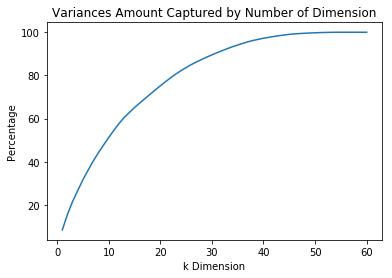

In [41]:
fig = plt.figure()
plt.plot(n_components, pca_var)
plt.title('Variances Amount Captured by Number of Dimension')
plt.ylabel('Percentage')
plt.xlabel('k Dimension')
plt.show()

In [42]:
#var = np.cumsum((pca.explained_variance_ratio_)*100) 
#var[]

**Note**: The var is an array showing cummulative sum of information captured by the features used. For example, the first feature, which captures the most information of the number of shares, explains 8.5% of the variance within out dataset. The first two features capture 15.6% of the variance within our dataset. 30 features can capture 90% of all variance within our dataset. 

In [43]:
def rmse_cal(model, X_train, Y_train, X_test, Y_test): 
    log_y_train = np.log(Y_train)
    log_y_test = np.log(Y_test)
    model.fit(X_train, log_y_train)
    log_y_pred = model.predict(X_test)
    return(rmse(log_y_test, log_y_pred))

In [44]:
def cv_rmse(model, pca_flag, X, Y, num_fold, alpha):
    cv_rmse = []
    for i in range(num_fold):
        X_train, X_test, Y_train, Y_test = train_test_split(
                    X, Y, test_size = 0.33)
        if pca_flag == True: 
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        if model == 'Lasso':
            model = make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))
        elif model == 'XGB':
            model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)    
        cv_rmse.append(rmse_cal(model, X_train, Y_train, X_test, Y_test))
    return cv_rmse

In [ ]:
XGB_rmse_score = cv_rmse('XGB', True, X, Y, 10, alpha)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(np.mean(cv_rmse_score), np.std(cv_rmse_score)))

In [ ]:
np.mean(XGB_rmse_score)

In [71]:
np.std(XGB_rmse_score)

0.0039772548669619922

In [46]:
Lasso_rmse_score = cv_rmse('Lasso', True, X, Y, 10, 0.07)
print("\nLasso score: {:.4f} ({:.4f})\n".format(np.mean(Lasso_rmse_score), np.std(Lasso_rmse_score)))


Lasso score: 0.9206 (0.0071)



# 4. Binary Classification

## 4.1. Investigate correlation of features with the targeted variable

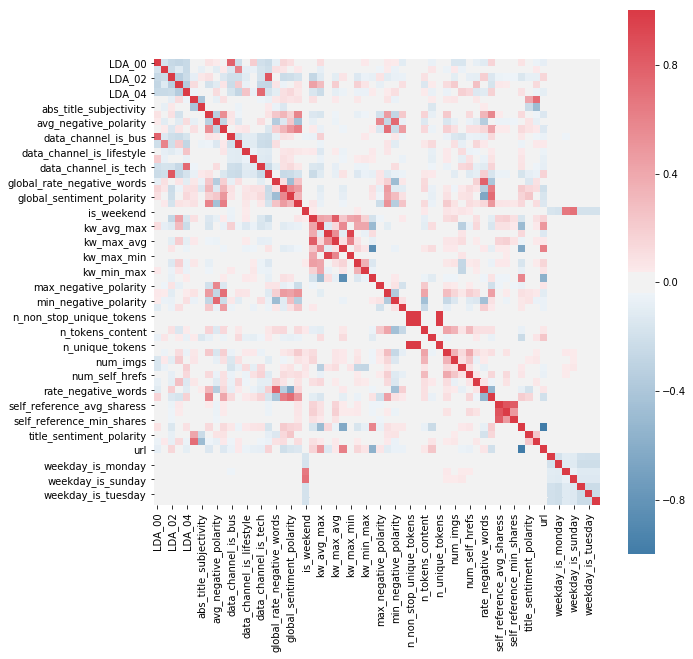

In [47]:
df_corr = data[data.columns.difference(['shares'])]
f, ax = plt.subplots(figsize = (10, 10))
corr = df_corr.corr()

sns.heatmap(corr, vmin = -1.0, vmax = 1.0, mask = np.zeros_like(corr, dtype = np.bool), 
            cmap = sns.diverging_palette(240, 10, as_cmap = True),
            square = True, ax = ax)
#plt.title('Correlation Matrix for All Features and Target')
#plt.show()

plt.savefig('corr.png')

In [48]:
data['popularity_2_level'] = np.where(data['shares'] <= 1400, 0, 1)
data = data.drop(['url', 'timedelta'], axis = 1)

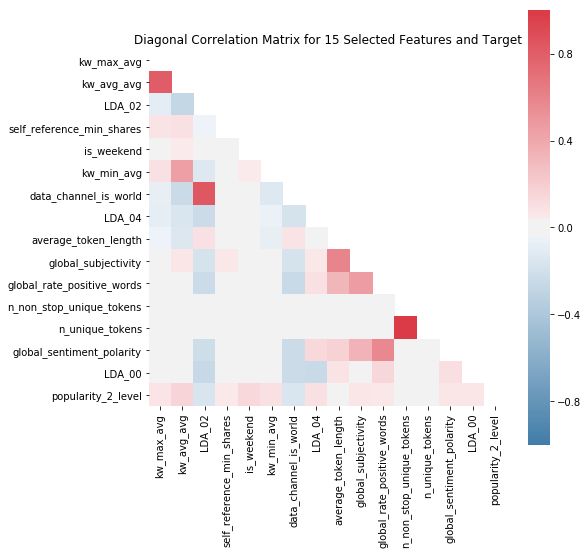

In [49]:
### correlation matrix for selected features

selected_features = ['kw_max_avg', 'kw_avg_avg', 'LDA_02','self_reference_min_shares',
                     'is_weekend', 'kw_min_avg','data_channel_is_world','LDA_04',
                     'average_token_length','global_subjectivity','global_rate_positive_words',
                     'n_non_stop_unique_tokens','n_unique_tokens','global_sentiment_polarity','LDA_00',
                     'popularity_2_level']

df_corr_2 = data[selected_features]

f, ax = plt.subplots(figsize = (8, 8))
corr_2 = df_corr_2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_2, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_2, vmin = -1.0, vmax = 1.0, mask = mask, 
            cmap = sns.diverging_palette(240, 10, as_cmap = True),
            square = True, ax = ax)
#plt.show()
plt.title('Diagonal Correlation Matrix for 15 Selected Features and Target')
plt.savefig('corr_2.png')

## 4.2. Feature selection

### 4.2.1. Set 1 of features using feature importance

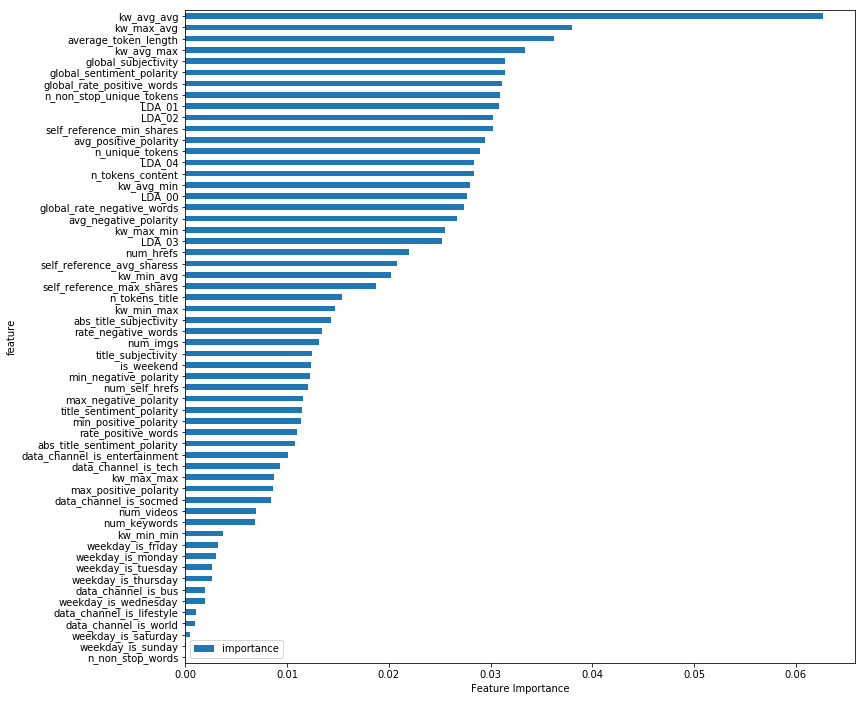

In [50]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')
df_X = data[data.columns.difference(['shares', 'popularity_2_level'])]
df_Y = data['popularity_2_level']
dtmodel = tree_clf.fit(df_X, df_Y)

feature_imp = pd.DataFrame({'importance' : dtmodel.feature_importances_})
feature_imp['feature'] = df_X.columns
feature_imp.sort_values(by = 'importance', ascending = True, inplace = True)
feature_imp = feature_imp.set_index('feature', drop = True)
feature_imp.plot.barh(figsize = (12, 12))
plt.xlabel('Feature Importance')
#plt.show()
plt.savefig('feat_imp.png')

In [51]:
feature_imp.sort_values(by = 'importance', ascending = False, inplace = True)
print("The 30 most important features")
print(feature_imp[:30])

The 30 most important features
                            importance
feature                               
kw_avg_avg                    0.062683
kw_max_avg                    0.038010
average_token_length          0.036258
kw_avg_max                    0.033347
global_subjectivity           0.031422
global_sentiment_polarity     0.031380
global_rate_positive_words    0.031150
n_non_stop_unique_tokens      0.030874
LDA_01                        0.030814
LDA_02                        0.030279
self_reference_min_shares     0.030252
avg_positive_polarity         0.029483
n_unique_tokens               0.028966
LDA_04                        0.028396
n_tokens_content              0.028376
kw_avg_min                    0.027920
LDA_00                        0.027676
global_rate_negative_words    0.027409
avg_negative_polarity         0.026685
kw_max_min                    0.025484
LDA_03                        0.025188
num_hrefs                     0.021937
self_reference_avg_sharess    0.0

In [52]:
## 1st set of 30 features using feature importance
selected1 = list(feature_imp[:30].index)
df_X_1 = df_X[selected1]
df_X_1.shape

(39644, 30)

### 4.2.2. Set 2 of features using Recursive Feature Elimination

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 30)
fit = rfe.fit(df_X, df_Y)
support = fit.support_
selected2 = list(df_X.columns[support])
df_X_2 = df_X[selected2]
print(df_X_2.shape)

(39644, 30)


### 4.2.3 Set 3 of features using greedy methods
1. A very thorough method to find the best subset. However, it is not guaranteed that the subset found is the best one for entire data configurations
2. We will use the metrics that improves the mean error differed by 1 std. Also, the loss function is log loss functions
3. reference: Brian Delassore feature selections

In [54]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [55]:
kfolds = KFold(n_splits = 5)
for train_index, test_index in kfolds.split(data):
    X_train = data.iloc[train_index]
    X_test = data.iloc[test_index]

In [56]:
def LogLoss(predict_prob, truth):
    return ((-1*(np.log(predict_prob))*(truth == 1) - (np.log(1-predict_prob))*(truth == 0)).mean())

In [57]:
#data.columns

In [58]:
X = data.drop('popularity_2_level',1)
y = data['popularity_2_level']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

In [59]:
for train_index, test_index in kfolds.split(X_train):
    temp = train_index
    X_train_sub = X_train.loc[train_index]

In [60]:
def train_iter(X_train, y_train):#X_trian here refers to the training set after the train_test split
    kfolds = KFold(n_splits = 5)
    loss_list = []
    for train_index, test_index in kfolds.split(X_train):
        X_train_sub = X_train.loc[train_index]
        X_val = X_train.loc[test_index]
        y_train_sub = y_train.loc[train_index]
        y_val = y_train.loc[test_index]
        
        estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)#Can be tuned
        ada_classifier = AdaBoostClassifier(estimator,n_estimators = 200, learning_rate = 0.03)
        ada_classifier.fit(X_train_sub, y_train_sub)
        predict_prob = ada_classifier.predict_proba(X_val)[:,1]
        
        log_loss = LogLoss(predict_prob, y_val)
        loss_list.append(log_loss)
        
    return (np.mean(loss_list), np.std(loss_list)/np.sqrt(len(loss_list)) )#standard deviation of the mean
        

In [64]:
def LrForward_LogLoss(X_train, y_train):
    results = {}
    curr_best = set()
    cand_list = set(X_train.columns.values)
    k = 1
    
    curr_best_mu = 10**10
    curr_best_serr = 10**10
    while True:
        prev_best_mu = curr_best_mu
        prev_best_serr = curr_best_serr
        for f in cand_list:
            use_x = list(curr_best) + [f]
            mu, serr = train_iter(X_train[use_x], y_train)
            if ((mu + serr) < (curr_best_mu + curr_best_serr)):
                curr_best_mu = mu
                curr_best_serr = serr
                best_f = f
        '''
        Now we have a curr_best_mu that is among all the one added. We first decide whether the improvement is substantial
        If the new best curr_best_mu is only slightly better than the previous one, we will just stop
        and take whatever is chose. 
        '''
        temp_prev = abs(prev_best_mu+ prev_best_serr)
        temp_curr = abs(curr_best_mu + curr_best_serr)
        print('The current prev and curr is {},{}'.format(temp_prev,temp_curr ))
        if  (abs((prev_best_mu+ prev_best_serr) - (curr_best_mu+curr_best_serr)) <= 0.00001):
            break;
        #If not, then add in the new best feature.
        curr_best.add(best_f) #Add the best feature to the curr_best_set
        cand_list = cand_list.difference(curr_best) #Remove the best feature from the candidate set
        results[k] = [list(curr_best), curr_best_mu, curr_best_serr]
        
    return results

In [ ]:
results = LrForward_LogLoss(X_train, y_train)

## 4.3. Logistic Regression

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(df_X_1, df_Y, test_size = 0.2, random_state = 1001)
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(df_X_2, df_Y, test_size = 0.2, random_state = 1001)

### 4.3.1. Default LR for feature set 1 and 2

In [66]:
lr = LogisticRegression()
lr.fit(X_train_1, Y_train_1)
preds_1 = lr.predict(X_test_1)
acc_1 = accuracy_score(Y_test_1, preds_1)
proba_1 = lr.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(Y_test_1, proba_1[:, 1])
roc_auc_1 = auc(fpr, tpr)
print('Accuracy(feat1, baseline): ', acc_1)
print('AUC(feat1, baseline)', roc_auc_1)

Accuracy(feat1, baseline):  0.6247950561230925
AUC(feat1, baseline) 0.6738677674275653


In [67]:
lr = LogisticRegression()
lr.fit(X_train_2, Y_train_2)
preds_2 = lr.predict(X_test_2)
acc_2 = accuracy_score(Y_test_2, preds_2)
proba_2 = lr.predict_proba(X_test_2)
fpr, tpr, thresholds = roc_curve(Y_test_2, proba_2[:, 1])
roc_auc_2 = auc(fpr, tpr)
print('Accuracy(feat2, baseline): ', acc_2)
print('AUC(feat2, baseline)', roc_auc_2)

Accuracy(feat2, baseline):  0.6302181864043385
AUC(feat2, baseline) 0.6807478624184626


### 4.3.2. LR with grid-search for best hyper-parameters

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

pipeline = Pipeline(steps)

param_grid_lr = dict(lr__C = [10**i for i in range(-5, 5)],
                     lr__penalty = ['l1', 'l2'])

kfolds = KFold(n_splits = 5)
lr_grid_search = GridSearchCV(pipeline, param_grid = param_grid_lr, cv = kfolds, scoring = 'roc_auc')

In [78]:
lr_grid_search.fit(X_train_1, Y_train_1)

# best AUC for the 1st set of features
best_1 = lr_grid_search.best_score_
print('best AUC for the 1st set of features: ', best_1)

# best estimator for the 1st set of features
print('best estimator for the 1st set of features:\n', lr_grid_search.best_estimator_)

best AUC for the 1st set of features:  0.6723394206238089
best estimator for the 1st set of features:
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


In [79]:
lr_grid_search.fit(X_train_2, Y_train_2)

# best AUC for the 2nd set of features
best_2 = lr_grid_search.best_score_
print('best AUC for the 2nd set of features: ', best_2)

# best estimator for the 2nd set of features
print('best estimator for the 2nd set of features:\n', lr_grid_search.best_estimator_)

best AUC for the 2nd set of features:  0.6718730927285423
best estimator for the 2nd set of features:
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


In [80]:
## final LR model: 1st set of features, C = 10000, penalty = 'l1'
lr_final = LogisticRegression(C = 10000, penalty = 'l1')
lr_final.fit(X_train_1, Y_train_1)

## Evaluate on the test set
preds = lr_final.predict(X_test_1)
acc = accuracy_score(Y_test_1, preds)
proba = lr_final.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(Y_test_1, proba[:, 1])
roc_auc = auc(fpr, tpr)
print('Accuracy(tuned): ', acc)
print('AUC(tuned)', roc_auc)

Accuracy(tuned):  0.6307226636398032
AUC(tuned) 0.6813929071172541


## 4.4. Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier

## 1st set of features
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train_1, Y_train_1)
preds_1 = clf.predict(X_test_1)
acc_1 = accuracy_score(Y_test_1, preds_1)
proba_1 = clf.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(Y_test_1, proba_1[:, 1])
roc_auc_1 = auc(fpr, tpr)
print('Accuracy(feat1, baseline): ', acc_1)
print('AUC(feat1, baseline): ', roc_auc_1)

Accuracy(feat1, baseline):  0.5667801740446462
AUC(feat1, baseline):  0.5668200957163101


In [82]:
## 2nd set of features

clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train_2, Y_train_2)
preds_2 = clf.predict(X_test_2)
acc_2 = accuracy_score(Y_test_2, preds_2)
proba_2 = clf.predict_proba(X_test_2)
fpr, tpr, thresholds = roc_curve(Y_test_2, proba_2[:, 1])
roc_auc_2 = auc(fpr, tpr)
print('Accuracy(feat2, baseline): ', acc_2)
print('AUC(feat2, baseline)', roc_auc_2)

Accuracy(feat2, baseline):  0.5629965947786606
AUC(feat2, baseline) 0.5629607405319311


In [83]:
## hyperparameters: max_depth, min_samples_split, min_samples_leaf

# GridSearchCV (first try)

kfolds = KFold(n_splits = 5)

param_grid_dt = {'max_depth': [5, 10, 15], 'min_samples_split': np.arange(800, 1300, step = 100), 
              'min_samples_leaf': np.arange(50, 200, step = 20)}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'), param_grid_dt, 
                              cv = kfolds, scoring = 'roc_auc')
dt_grid_search.fit(df_X, df_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15], 'min_samples_split': array([ 800,  900, 1000, 1100, 1200]), 'min_samples_leaf': array([ 50,  70,  90, 110, 130, 150, 170, 190])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [85]:
print("Best score for grid search")
print(dt_grid_search.best_score_)

print("Best parameters")
print(dt_grid_search.best_params_)

Best score for grid search
0.6836401480308408
Best parameters
{'max_depth': 15, 'min_samples_leaf': 70, 'min_samples_split': 800}


In [86]:
def dtmodel1(d, msl, X_train, Y_train, X_test, Y_test):
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = d, min_samples_leaf = msl)
    clf.fit(X_train, Y_train)
    return roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])

In [ ]:
depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
leaves = [int(x) for x in np.linspace(50, 800, 10)]

In [88]:
results = {}

for depth in depths:
    results[depth] = []
    for leaf in leaves:
        results[depth].append(dtmodel1(depth, leaf, X_train_1, Y_train_1, X_test_1, Y_test_1))

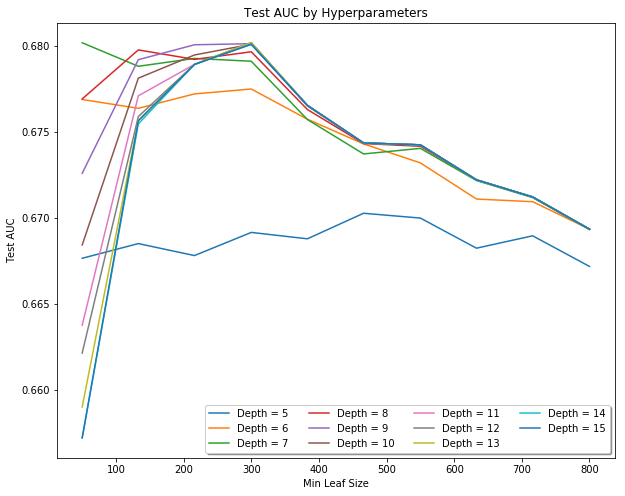

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

for depth in depths:
    plt.plot(leaves, results[depth], 
             label = 'Depth = {}'.format(depth))

#ax.legend(loc = 'upper center', bbox_to_anchor = (1.1, 1), 
          #fancybox = True, shadow = True, ncol = 1, prop = {'size': 10})
    
ax.legend(loc = 4, 
          fancybox = True, shadow = True, ncol = 4, prop = {'size': 10})
    
ax.set_xlabel('Min Leaf Size') 
ax.set_ylabel('Test AUC')
plt.title('Test AUC by Hyperparameters')
#plt.show() 
plt.savefig('tuning1.png')

In [91]:
splits = [100, 200, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600]
new_leaves = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

In [93]:
new_results = {}

for leaf in new_leaves:
    new_results[leaf] = []
    for min_samples_split in splits:
        clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = leaf, max_depth = 8,
                                      min_samples_split = min_samples_split)
        dtmodel = clf.fit(X_train_1, Y_train_1)
        new_results[leaf].append(roc_auc_score(Y_test_1, dtmodel.predict_proba(X_test_1)[:,1]))

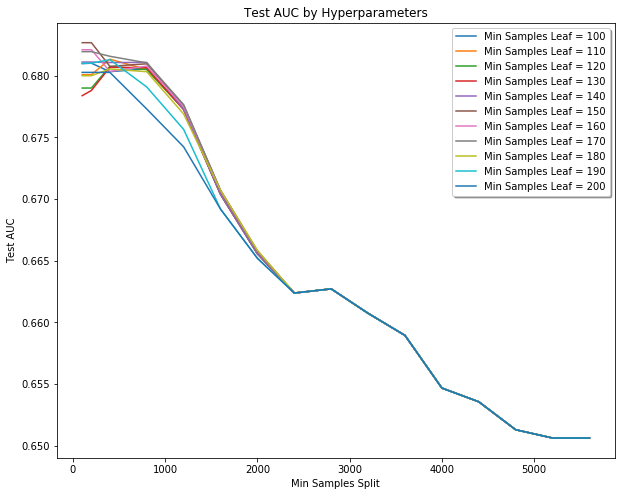

In [95]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

for leaf in new_leaves:
    plt.plot(splits, new_results[leaf], 
             label = 'Min Samples Leaf = {}'.format(leaf))

ax.legend(loc = 'upper right', fancybox = True, shadow = True, ncol = 1, prop = {'size': 10})
ax.set_xlabel('Min Samples Split') 
ax.set_ylabel('Test AUC')
plt.title('Test AUC by Hyperparameters')
#plt.show()
plt.savefig('tuning2.png')

In [98]:
## depths = [7, 8, 9], min_samples_leaf = (100, 200), min_samples_split = (100, 800) 
## Run GridSearchCV again

kfolds = KFold(n_splits = 5)

param_grid_dt = {'max_depth': [7, 8, 9], 'min_samples_split': np.arange(100, 800, step = 100), 
                 'min_samples_leaf': np.arange(50, 150, step = 20)}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'), param_grid_dt, 
                              cv = kfolds, scoring = 'roc_auc')
dt_grid_search.fit(X_train_1, Y_train_1)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [7, 8, 9], 'min_samples_split': array([100, 200, 300, 400, 500, 600, 700]), 'min_samples_leaf': array([ 50,  70,  90, 110, 130])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [99]:
print("Best score for grid search")
print(dt_grid_search.best_score_)

print("Best parameters")
print(dt_grid_search.best_params_)

Best score for grid search
0.6682314445615682
Best parameters
{'max_depth': 7, 'min_samples_leaf': 130, 'min_samples_split': 600}


In [103]:
## visualize the optimal tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus
dot_data = StringIO()


dt_final = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 600, 
                                   min_samples_leaf = 130, max_depth = 7)
dt_final.fit(X_train_1, Y_train_1)

dot_data = StringIO()
tree.export_graphviz(dt_final, out_file = dot_data, feature_names = X_train_1.columns,
                     filled = True, rounded = True, special_characters = True)

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())
#graph.write_png("tree.png")

In [104]:
## Evaluate the optimal tree on the test set

preds = dt_final.predict(X_test_1)
acc = accuracy_score(Y_test_1, preds)
proba = dt_final.predict_proba(X_test_1)
fpr, tpr, thresholds = roc_curve(Y_test_1, proba[:, 1])
roc_auc = auc(fpr, tpr)
print('Accuracy(tuned): ', acc)
print('AUC(tuned)', roc_auc)

Accuracy(tuned):  0.6318577374195989
AUC(tuned) 0.6806028116745647


In [ ]:
# 3rd set of features
key_features = list(results[1][0])
X_fs = data[key_features]
y_fs = data['popularity_2_level']
AUCs = []
fprs = []
tprs = []
f1_scores = []

In [ ]:
X_train_fs, X_test_fs, y_train_fs,y_test_fs = train_test_split(X_fs, y_fs, test_size = 0.2)
dt_fs = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
dt_fs.fit(X_train_fs, y_train_fs)
print("Decision Tree score: {}".format(dt_fs.score(X_test_fs, y_test_fs)))
f1_score_dt = metrics.f1_score(y_test_fs, dt_fs.predict(X_test_fs))
fpr_dt, tpr_dt,_ = metrics.roc_curve(y_test_fs, dt_fs.predict_proba(X_test_fs)[:,1])
auc_dt = metrics.auc(fpr_dt, tpr_dt)
f1_scores.append(f1_score_dt)
fprs.append(fpr_dt)
tprs.append(tpr_dt)
AUCs.append(auc_dt)

## 4.5. Random Forest

In [ ]:
rf_fs = RandomForestClassifier(n_estimators = 250,max_features = 6)
rf_fs.fit(X_train_fs, y_train_fs)
print("Random Forest Score: {}'.format(rf_fs.score(X_test_fs, y_test_fs)))
f1_score_rf = metrics.f1_score(y_test_fs, rf_fs.predict(X_test_fs))
fpr_rf, tpr_rf ,_ = metrics.roc_curve(y_test_fs, rf_fs.predict_proba(X_test_fs)[:,1])
auc_rf = metrics.auc(fpr_rf, tpr_rf)
f1_scores.append(f1_score_rf)
fprs.append(fpr_rf)
tprs.append(tpr_rf)
AUCs.append(auc_rf)

In [ ]:
roc_labels = []

roc_labels.append('Decision Tree AUC: {0:2f}'.format(0.68153))
roc_labels.append('AdaBoost Classifer AUC: {0:2f}'.format(AUCs[1]))
roc_labels.append('Gradient Boosting AUC: {0:2f}'.format(AUCs[2]))
roc_labels.append('XGBoost AUC: {0:2f}'.format(AUCs[3]))
roc_labels.append('Random Forest AUC: {0:2f}'.format(AUCs[4]))

ax = plt.subplots()
for i in range(5):
    plt.plot(fprs[i], tprs[i],label = roc_labels[i])
    
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve under feature selection")
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.show()
plt.savefig('biny_class_roc.png')

## 4.6. AdaBossting

In [ ]:
estimator = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 256)
ad_fs = AdaBoostClassifier(estimator, learning_rate =0.03, n_estimators = 250)
ad_fs.fit(X_train_fs, y_train_fs)
print("AdaBossting score: {}".format(ad_fs.score(X_test_fs, y_test_fs)))
f1_score_ad = metrics.f1_score(y_test_fs, ad_fs.predict(X_test_fs))
fpr_ad, tpr_ad,_ = metrics.roc_curve(y_test_fs, ad_fs.predict_proba(X_test_fs)[:,1])
auc_ad = metrics.auc(fpr_ad, tpr_ad)
f1_scores.append(f1_score_ad)
fprs.append(fpr_ad)
tprs.append(tpr_ad)
AUCs.append(auc_ad)

## 4.7. Gradient Boosting

In [ ]:
gb_fs = GradientBoostingClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)
gb_fs.fit(X_train_fs, y_train_fs)
print("Gradient Boosting Score {}".format(gb_fs.score(X_test_fs, y_test_fs)))
f1_score_gb = metrics.f1_score(y_test_fs, gb_fs.predict(X_test_fs))
fpr_gb, tpr_gb,_ = metrics.roc_curve(y_test_fs, gb_fs.predict_proba(X_test_fs)[:,1])
auc_gb = metrics.auc(fpr_gb, tpr_gb)
f1_scores.append(f1_score_gb)
fprs.append(fpr_gb)
tprs.append(tpr_gb)
AUCs.append(auc_gb)

## 4.8. XGBoost

In [ ]:
xgb_fs = XGBClassifier(max_depth = 10, learning_rate = 0.03, n_estimators = 250)
xgb_fs.fit(X_train_fs, y_train_fs)
print("XGBoost score: {}".format(xgb_fs.score(X_test_fs, y_test_fs)))
f1_score_xgb = metrics.f1_score(y_test_fs, xgb_fs.predict(X_test_fs))
fpr_xgb, tpr_xgb,_ = metrics.roc_curve(y_test_fs, xgb_fs.predict_proba(X_test_fs)[:,1])
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
f1_scores.append(f1_score_xgb)
fprs.append(fpr_xgb)
tprs.append(tpr_xgb)
AUCs.append(auc_xgb)

## 4.9 K-Nearest Neighbor 

In [69]:
neighbors = np.arange(10, 250, 50)
train_acc = []
test_acc = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

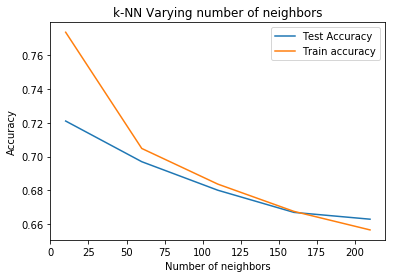

In [70]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_acc, label='Test Accuracy')
plt.plot(neighbors, train_acc, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We can see that the maximum test accuracy is received by k in the range of 60-70. Let's check the range near this and try to find a more accurate value. 

In [50]:
neighbors = np.arange(60, 70)
train_acc = []
test_acc = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

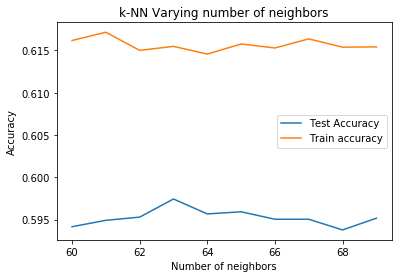

In [51]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_acc, label='Test Accuracy')
plt.plot(neighbors, train_acc, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

It's clear that 63 nearest neighbors gives us the best test accuracy. Let's fit our model to this value. 

In [52]:
knn = KNeighborsClassifier(n_neighbors=63)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5974271660991298

Our model achieves an accuracy of 59%.

In [55]:
# roc score
y_pred = knn.predict_proba(X_test)[:,1]
knn.score(X_test, y_test)
metrics.roc_auc_score(y_test,y_pred)

0.6265579606065822

And the AUC score is 0.62645 which is the best performance.

## Gaussian Naive Bayes

In [58]:
clf_gnb = GaussianNB().fit(X_train, y_train)
y_pred = clf_gnb.predict(X_test)
print('Accuracy: ', clf_gnb.score(X_test, y_test))
print('AUC: ', metrics.roc_auc_score(y_test,y_pred))

Accuracy:  0.5056123092445454
AUC:  0.5335804352123696
